In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers.core import Dense, Activation, Dropout
import time  # helper libraries

from dataset_window import Dataset


def convertCash(cash):
	cash = cash.replace('.', '')
	cash = cash.replace(',', '.')
	return float(cash)


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], [] 
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])

	return np.array(dataX), np.array(dataY)

#Carregando os dados
data = pd.read_csv("onion_price2.csv", parse_dates=['Mês'])
data.set_index('Mês', inplace=True)
index = data.index.values
print(index)
data['Preço'] = data['Preço'].apply(convertCash)
data['PREÇO_DOLAR'] = data['PREÇO_DOLAR'].apply(convertCash)

['2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000'
 '2016-09-01T00:00:00.000000000' '2016-10-01T00:00:00.000000000'
 '2016-11-01T00:00:00.000000000' '2016-12-01T00:00:00.000000000'
 '2017-01-01T00:00:00.000000000' '2017-02-01T00:00:00.000000000'
 '2017-03-01T00:00:00.000000000' '2017-04-01T00:00:00.000000000'
 '2017-05-01T00:00:00.000000000' '2017-06-01T00:00:00.000000000'
 '2017-07-01T00:00:00.000000000' '2017-08-01T00:00:00.000000000'
 '2017-09-01T00:00:00.000000000' '2017-10-01T00:00:00.000000000'
 '2017-11-01T00:00:00.000000000' '2017-12-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-03-01T00:00:00.000000000' '2018-04-01T00:00:00.000000000'
 '2018-05-01T00:00:00.000000000' '2018-06-01T00:00:00.000000000'
 '2018-07-01T00:00:00.000

In [2]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_dollar = MinMaxScaler(feature_range=(0,1))
data['Preço'] = scaler_price.fit_transform(data['Preço'].to_numpy().reshape(-1, 1))
data['PREÇO_DOLAR'] = scaler_dollar.fit_transform(data['PREÇO_DOLAR'].to_numpy().reshape(-1, 1))

In [3]:
x,y = create_dataset(data.values, 4)

In [4]:
train_x, test_x = x[0:32, :], x[32:, :]

train_y, test_y = y[0:32], y[32:]

print(test_y.shape)

(12,)


In [5]:
model = Sequential()
model.add(LSTM(25, input_shape=(4, 2)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, verbose=1)

trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0545
Epoch 2/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0527
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0532
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0526
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0485
Epoch 7/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0456
Epoch 8/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0448
Epoch 9/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 10/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 11/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0404
Epoch 12/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0425
Epoch 13/1000
1/1 [==============================]

In [6]:
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

In [7]:
trainPredict = scaler_price.inverse_transform(trainPredict)
train_y = scaler_price.inverse_transform([train_y])

testPredict = scaler_price.inverse_transform(testPredict)
test_y = scaler_price.inverse_transform([test_y])

print(testPredict)

[[77.73712 ]
 [72.335945]
 [39.34135 ]
 [20.871792]
 [30.943325]
 [30.608929]
 [55.148624]
 [82.90311 ]
 [59.45692 ]
 [27.321072]
 [24.066793]
 [23.01613 ]]


In [8]:
#calculate mean absolute error
mape_train = mean_absolute_percentage_error(train_y[0], trainPredict)
print('Train Score: %.2f MAPE' % (mape_train))
mape_test = mean_absolute_percentage_error(test_y[0], testPredict)
print('Test Score: %.2f MAPE' % (mape_test))
print('\n -----------------------------------------\n')
#calculate mean absolute error
mae_train = mean_absolute_error(train_y[0], trainPredict)
print('Train Score: %.2f MAE' % (mae_train))
mae_test = mean_absolute_error(test_y[0], testPredict)
print('Test Score: %.2f MAE' %(mae_test))
print('\n -----------------------------------------\n')
# calculate root mean squared error
rmse_train = math.sqrt(mean_squared_error(train_y[0], trainPredict))
print('Train Score: %.2f RMSE' % (rmse_train))
rmse_test = math.sqrt(mean_squared_error(test_y[0], testPredict))
print('Test Score: %.2f RMSE' % (rmse_test))

Train Score: 0.22 MAPE
Test Score: 0.24 MAPE

 -----------------------------------------

Train Score: 4.63 MAE
Test Score: 11.30 MAE

 -----------------------------------------

Train Score: 5.86 RMSE
Test Score: 15.10 RMSE


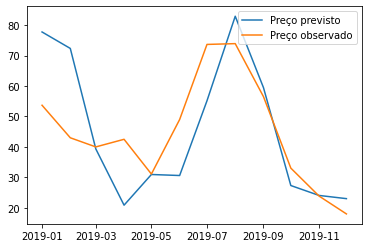

In [9]:
plt.plot(index[36:], testPredict, label='Preço previsto')
plt.plot(index[36:], test_y.reshape(-1, 1), label='Preço observado')
plt.legend()
plt.show()